# Teaching machines to see better: Improving CNNs and making them confess

<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch06/7.1.Image_Classification_Advance.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

## Importing necessary libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import requests
print(tf.__version__)
import zipfile
import requests
import os
import time
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import tensorflow.keras.backend as K
import pickle
from tensorflow.keras.models import load_model, Model

random_seed = 4321
np.random.seed(random_seed)
seed=4321
random.seed(seed)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass

2.1.0


## Downloading data

For this chapter, we're going to use the tiny-imagenet dataset (200 categories of objects). This is a simplified version of the bigger and harder imagenet dataset (1000 categories of objects).

In [4]:
import os
import requests
import zipfile

# Retrieve the data
if not os.path.exists(os.path.join('data','tiny-imagenet-200.zip')):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')

    with open(os.path.join('data','tiny-imagenet-200.zip'), 'wb') as f:
        f.write(r.content)
    
    with zipfile.ZipFile(os.path.join('data','tiny-imagenet-200.zip'), 'r') as zip_ref:
        zip_ref.extractall('data')
else:
    if not os.path.exists('data/tiny-imagenet-200'):
        with zipfile.ZipFile(os.path.join('data','tiny-imagenet-200.zip'), 'r') as zip_ref:
            zip_ref.extractall('data')
    else:
        print("The data already exists.")

## Results from the EDA

* There are 200 classes of data
* Each image is 64x64 RGB
* Training data has 500 images per each class
* Testing has 50 images per each class
* We separate 50 images from each class in the training set to create the validation set

```
n02124075 	Egyptian cat
n04067472 	reel
n04540053 	volleyball
n04099969 	rocking chair, rocker
n07749582 	lemon
```

## Creating a validation set

In the dataset, we currently have a,

* Training set: `train` directory
* Testing set: `val` directory

But to properly train a model we need three datasets,

* Training set - Used to train the model
* Validation set - Used to continuously monitor model performance while training
* Testing set - Used to test the model, only after training finishes

Therefore, we will separate a 10% from training data as validation data to a new folder `train_val`

In [5]:
import os
import random
seed=4321
random.seed(seed)

def create_validation_set(src_dir, dst_dir, validation_split=0.2):
    # Create the directori if doesn't exist
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    # Got through each sub dir in the folder
    for f in os.listdir(src_dir):        
        if os.path.isdir(os.path.join(src_dir,f)):                 
            sub_dir = os.path.join(src_dir, f, 'images')                        
            target_sub_dir = os.path.join(dst_dir, f, 'images')
            # For each subfolder create a subfolder in the destination directory
            if not os.path.exists(target_sub_dir):
                os.makedirs(target_sub_dir)
            # All the images in the training sub dir
            sub_images = [os.path.join(sub_dir, ff) for ff in os.listdir(sub_dir) if ff.lower().endswith('jpeg')]
            # Create a random sample from the training data
            val_images = random.sample(sub_images, int(len(sub_images)*validation_split))
            # Copy the data to the validation directory
            for vimg in val_images:
                shutil.move(vimg, target_sub_dir)

if not os.path.exists(os.path.join('data','tiny-imagenet-200', 'train_val')):
    create_validation_set(
        os.path.join('data','tiny-imagenet-200', 'train'), 
        os.path.join('data','tiny-imagenet-200', 'train_val'), 
        0.1)
else:
    print("The directory {} already exists. If you need to separate the validation set again, follow the following steps.\n"+
         ("1. Delete the tiny-imagenet-200 folder.\n2.Extract the tiny-imagenet-200.zip in place.\n3.Run this cell"))

## Creating the data generators

In [37]:
def get_test_labels_df(test_labels_path):
    """ Reading the test data labels for all files in the test set as a data frame """
    test_df = pd.read_csv(test_labels_path, sep='\t', index_col=None, header=None)
    test_df = test_df.iloc[:,[0,1]].rename({0:"filename", 1:"class"}, axis=1)
    return test_df

def data_gen_crop(gen, random_gamma=False, random_occlude=False):
    for x,y in gen: 
        if random_gamma:
            # Gamma correction
            # Doing this in the image process fn doesn't help improve performance
            rand_gamma = np.random.uniform(0.9, 1.08, (x.shape[0],1,1,1))
            x = x**rand_gamma
            
        if random_occlude:
            # Randomly occluding sections in the image
            occ_size = 10
            occ_h, occ_w = np.random.randint(0, x.shape[0]-occ_size), np.random.randint(0, x.shape[0]-occ_size)
            x[::2,occ_h:occ_h+occ_size,occ_w:occ_w+occ_size,:] = np.random.choice([0.,128.,255.])
        
        # Image centering
        x -= np.mean(x, axis=(1,2,3), keepdims=True)
        
        # Making sure we replicate the target (y) three times
        yield x,(y,y,y)
        

def get_train_valid_test_data_generators(batch_size):
    
    # Defining the train data generator
    train_gen = ImageDataGenerator(
        samplewise_center=False, rotation_range=30, width_shift_range=0.2,
        height_shift_range=0.2, brightness_range=(0.5,1.5), shear_range=5, 
        zoom_range=0.2, horizontal_flip=True, fill_mode='reflect'
    ).flow_from_directory(
        os.path.join('data','tiny-imagenet-200', 'train'), target_size=(64, 64), classes=None,
        class_mode='categorical', batch_size=batch_size, shuffle=True, seed=random_seed
    )

    # Defining the valid data generator
    valid_gen = ImageDataGenerator(samplewise_center=False).flow_from_directory(
        os.path.join('data','tiny-imagenet-200',  'train_val'), target_size=(64, 64), classes=None,
        class_mode='categorical', batch_size=batch_size, shuffle=False, seed=random_seed
    )

    # Defining the test data generator
    test_df = get_test_labels_df(os.path.join('data','tiny-imagenet-200',  'val', 'val_annotations.txt'))
    test_gen = image_gen.flow_from_dataframe(
        test_df, directory=os.path.join('data','tiny-imagenet-200',  'val', 'images'), target_size=(64, 64), classes=None,
        class_mode='categorical', batch_size=batch_size, shuffle=False
    )
    return train_gen, valid_gen, test_gen

batch_size = 128
# Getting the train,valid, test data generators
train_gen, valid_gen, test_gen = get_train_valid_test_data_generators(batch_size)
# Modifying the data generators to fit the model targets
# We augment data in the training set
train_gen_aux = data_gen_crop(train_gen, random_gamma=True, random_occlude=True)
# We do not augment data in the validation/test datasets
valid_gen_aux = data_gen_crop(valid_gen)
test_gen_aux = data_gen_crop(test_gen)

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


## Plotting the augmented images

Here we will plot some of the training images (augmented) as well as validation images (not augmented). This also acts as a verification step to make sure we have desired augmentations applied to correct datasets.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

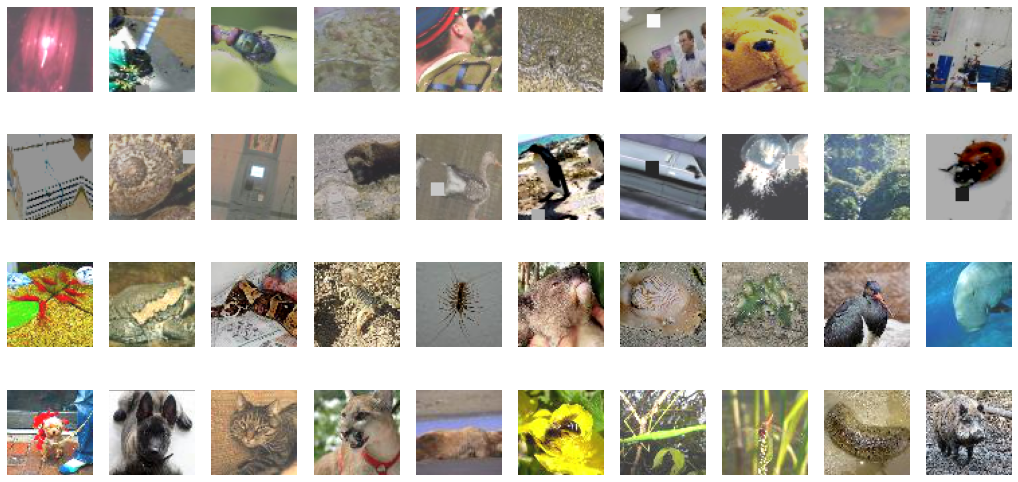

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

data = [] # Holds both training and validation samples to be plotted

# Getting training samples (20 samples)
for i, (x,y) in enumerate(train_gen_aux):
    if i>=20: break
    data.append((x[0,:,:,:]+128).astype('int32'))
    
# Getting validation samples (20 samples)
for i,(x,y) in enumerate(valid_gen_aux):
    if i>=20: break
    data.append((x[0,:,:,:]+128).astype('int32'))
    
# Creating a plot with 40 subplots (4 rows and 10 columns)
n_rows = 4
n_cols = 10
f, axes = plt.subplots(n_rows, n_cols, figsize=(18,9))

# Plot the training and validation images
# First 2 rows are training data
# Second 2 rows are validation data
for ri in range(n_rows):
    for ci in range(n_cols):
        i = ri*n_cols + ci
        axes[ri][ci].imshow(data[i])
        axes[ri][ci].axis('off')

## Inception v1 network

## init defaults to glorot_uniform

In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K


def inception(inp, n_filters):

    # 1x1 layer
    out1 = Conv2D(n_filters[0][0], (1,1), strides=(1,1), activation='relu', padding='same')(inp)

    # 1x1 followed by 3x3
    out2_1 = Conv2D(n_filters[1][0], (1,1), strides=(1,1), activation='relu', padding='same')(inp)
    out2_2 = Conv2D(n_filters[1][1], (3,3), strides=(1,1), activation='relu', padding='same')(out2_1)

    # 1x1 followed by 5x5
    out3_1 = Conv2D(n_filters[2][0], (1,1), strides=(1,1), activation='relu', padding='same')(inp)
    out3_2 = Conv2D(n_filters[2][1], (5,5), strides=(1,1), activation='relu', padding='same')(out3_1)

    # 3x3 (pool) followed by 1x1
    out4_1 = MaxPool2D((3,3), strides=(1,1), padding='same')(inp)
    out4_2 = Conv2D(n_filters[3][0], (1,1), strides=(1,1), activation='relu', padding='same')(out4_1)

    out = Concatenate(axis=-1)([out1, out2_2, out3_2, out4_2])
    return out

def aux_out(inp,name=None):    
    avgpool1 = AvgPool2D((5,5), strides=(1,1), padding='same')(inp)
    conv1 = Conv2D(128, (1,1), activation='relu', padding='same')(avgpool1)
    flat = Flatten()(conv1)
    dense1 = Dense(1024, activation='relu')(flat)    
    aux_out = Dense(200, activation='softmax', name=name)(dense1)
    return aux_out

def stem(inp):
    conv1 = Conv2D(64, (7,7), strides=(2,2), activation='relu', padding='same')(inp)
    lrn1 = Lambda(lambda x: tf.nn.local_response_normalization(x))(conv1)

    conv2 = Conv2D(64, (1,1), strides=(1,1), padding='same')(lrn1)
    conv3 = Conv2D(192, (3,3), strides=(1,1), activation='relu', padding='same')(conv2)
    lrn2 = Lambda(lambda x: tf.nn.local_response_normalization(x))(conv3)

    maxpool = MaxPool2D((3,3), strides=(2,2), padding='same')(lrn2)

    return maxpool
    
def inception_v1():
    
    K.clear_session()
    
    inp = Input(shape=(64,64,3))
    stem_out = stem(inp)
    inc_3a = inception(stem_out, [(64,),(96,128),(16,32),(32,)])
    inc_3b = inception(inc_3a, [(128,),(128,192),(32,96),(64,)])

    maxpool = MaxPool2D((3,3), strides=(2,2), padding='same')(inc_3b)

    inc_4a = inception(maxpool, [(192,),(96,208),(16,48),(64,)])
    inc_4b = inception(inc_4a, [(160,),(112,224),(24,64),(64,)])

    aux_out1 = aux_out(inc_4a, name='aux1')

    inc_4c = inception(inc_4b, [(128,),(128,256),(24,64),(64,)])
    inc_4d = inception(inc_4c, [(112,),(144,288),(32,64),(64,)])
    inc_4e = inception(inc_4d, [(256,),(160,320),(32,128),(128,)])

    aux_out2 = aux_out(inc_4d, name='aux2')

    inc_5a = inception(inc_4e, [(256,),(160,320),(32,128),(128,)])
    inc_5b = inception(inc_5a, [(384,),(192,384),(48,128),(128,)])
    avgpool1 = AvgPool2D((8,8), strides=(1,1), padding='valid')(inc_5b)

    flat_out = Flatten()(avgpool1)
    out_main = Dense(200, activation='softmax', name='final')(flat_out)

    model = Model(inputs=inp, outputs=[out_main, aux_out1, aux_out2])
    model.compile(loss='categorical_crossentropy', 
                       optimizer='adam', metrics=['accuracy'])
    return model

model = inception_v1()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   4160        lambda[0][0]                     
______________________________________________________________________________________________

## Metrics that we'll be looking at

In [13]:
print(model.metrics_names)

['loss', 'final_loss', 'aux1_loss', 'aux2_loss', 'final_accuracy', 'aux1_accuracy', 'aux2_accuracy']


## Training the model

In [6]:
def get_steps_per_epoch(n_data, batch_size):
    if n_data%batch_size==0:
        return int(n_data/batch_size)
    else:
        return int(n_data*1.0/batch_size)+1

In [20]:
es_callback = EarlyStopping(monitor='val_loss', patience=5)
csv_logger = CSVLogger(os.path.join('eval','2_eval_data_aug_early_stopping.log'))

t1 = time.time()
history = model.fit(
    train_gen_aux, validation_data=valid_gen_aux, 
    steps_per_epoch=int(0.9*(500*200)/batch_size), validation_steps=int(0.1*(500*200)/batch_size),
    epochs=50, callbacks=[es_callback, csv_logger]
)
t2 = time.time()

print("It took {} seconds to complete the training".format(t2-t1))

Train for 703 steps, validate for 78 steps
Epoch 1/50
703/703 [==============================] - 159s 227ms/step - loss: 9.2778 - final_loss: 5.1577 - aux1_loss: 5.1356 - aux2_loss: 5.1646 - final_accuracy: 0.0111 - aux1_accuracy: 0.0141 - aux2_accuracy: 0.0109 - val_loss: 8.9788 - val_final_loss: 5.0068 - val_aux1_loss: 4.9373 - val_aux2_loss: 4.9927 - val_final_accuracy: 0.0184 - val_aux1_accuracy: 0.0254 - val_aux2_accuracy: 0.0222
Epoch 2/50
703/703 [==============================] - 154s 219ms/step - loss: 8.8251 - final_loss: 4.8993 - aux1_loss: 4.8862 - aux2_loss: 4.9284 - final_accuracy: 0.0281 - aux1_accuracy: 0.0316 - aux2_accuracy: 0.0261 - val_loss: 8.4260 - val_final_loss: 4.7002 - val_aux1_loss: 4.6225 - val_aux2_loss: 4.6919 - val_final_accuracy: 0.0553 - val_aux1_accuracy: 0.0636 - val_aux2_accuracy: 0.0493
Epoch 3/50
703/703 [==============================] - 154s 220ms/step - loss: 8.3842 - final_loss: 4.6368 - aux1_loss: 4.6614 - aux2_loss: 4.7070 - final_accuracy: 0

Epoch 22/50
703/703 [==============================] - 155s 220ms/step - loss: 6.1298 - final_loss: 3.2344 - aux1_loss: 3.6342 - aux2_loss: 3.6042 - final_accuracy: 0.2624 - aux1_accuracy: 0.1937 - aux2_accuracy: 0.1997 - val_loss: 5.8617 - val_final_loss: 3.1539 - val_aux1_loss: 3.3960 - val_aux2_loss: 3.3735 - val_final_accuracy: 0.2816 - val_aux1_accuracy: 0.2387 - val_aux2_accuracy: 0.2415
Epoch 23/50
703/703 [==============================] - 154s 219ms/step - loss: 6.0841 - final_loss: 3.2040 - aux1_loss: 3.6191 - aux2_loss: 3.5812 - final_accuracy: 0.2673 - aux1_accuracy: 0.1983 - aux2_accuracy: 0.2048 - val_loss: 5.7855 - val_final_loss: 3.1046 - val_aux1_loss: 3.3688 - val_aux2_loss: 3.3335 - val_final_accuracy: 0.2878 - val_aux1_accuracy: 0.2374 - val_aux2_accuracy: 0.2500
Epoch 24/50
703/703 [==============================] - 154s 219ms/step - loss: 6.0484 - final_loss: 3.1785 - aux1_loss: 3.6066 - aux2_loss: 3.5680 - final_accuracy: 0.2724 - aux1_accuracy: 0.1990 - aux2_acc

In [22]:
if not os.path.exists('models'):
    os.mkdir("models")
model.save(os.path.join('models', 'inception_v1_data_aug_early_stopping.h5'))

## Test set per-class accuracies

In [16]:
test_preds, _, _ = model.predict(test_gen_aux, steps=get_steps_per_epoch(500*20, batch_size))
test_preds = np.argmax(test_preds, axis=-1)

(10000,)


In [36]:
def get_tiny_imagenet_classes(wnids_path, words_path):
    wnids = pd.read_csv(wnids_path, header=None, squeeze=True)
    words = pd.read_csv(words_path, sep='\t', index_col=0, header=None)
    words_200 = words.loc[wnids].rename({1:'class'}, axis=1)
    words_200.index.name = 'wnid'
    return words_200.reset_index()

def get_best_and_worst_classes(label_df, test_preds, class_indices):
        
    def accuracy(x):
        return (x["pred_label"]==x["true_label"].iloc[0]).sum()/x.shape[0]

    test_results = label_df.copy()
    test_results["true_label"] = test_results["class"].map(class_indices)
    test_results["pred_label"] = test_preds
    per_class_acc = test_results[["class", "true_label", "pred_label"]].groupby("class").apply(
        lambda x: accuracy(x)).sort_values()
    labels = get_tiny_imagenet_classes(wnids_path, words_path).set_index("wnid")["class"]
    per_class_acc = pd.DataFrame(per_class_acc, index=per_class_acc.index, columns=["accuracy"])
    per_class_acc.loc[labels.index, "class_description"] = labels
    print(per_class_acc.head(n=10))
    print(per_class_acc.tail(n=10))
    return {'best': per_class_acc.iloc[-10:], 'worst': per_class_acc.iloc[:10]}

class_indices = test_gen.class_indices
best_and_worst_cls = get_best_and_worst_classes(test_df, test_preds, class_indices)

           accuracy          class_description
class                                         
n04376876      0.02                    syringe
n03970156      0.04  plunger, plumber's helper
n02099712      0.06         Labrador retriever
n03992509      0.06             potter's wheel
n02113799      0.06            standard poodle
n04560804      0.06                  water jug
n04507155      0.06                   umbrella
n02906734      0.08                      broom
n04067472      0.08                       reel
n02823428      0.08                beer bottle
           accuracy                                  class_description
class                                                                 
n04486054      0.56                                     triumphal arch
n02892201      0.56                     brass, memorial tablet, plaque
n07920052      0.60                                           espresso
n02279972      0.62  monarch, monarch butterfly, milkweed butterfly...
n02917067 

## Plot some images of best and worst classes

In [ ]:
def plot_images(img_dir, classes, descriptions, images_per_class=5):
    n_classes = len(classes["best"]) + len(classes["worst"])
    f, axes = plt.subplots(n_classes, images_per_class)
    
    

## MInception Resnet v2

http://cs231n.stanford.edu/reports/2017/pdfs/930.pdf

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, AvgPool2D, Dense, Concatenate, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

K.clear_session()
def get_minception_resnet_v2():
    
    def inception_resnet_b(inp, n_filters, initializer, activation='relu', bn=True, res_w=0.1):
        out1_1 = Conv2D(n_filters[0][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out1_1 = BatchNormalization()(out1_1)
        
        out2_1 = Conv2D(n_filters[1][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out2_1 = BatchNormalization()(out2_1)
        out2_2 = Conv2D(n_filters[1][1], (1,7), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out2_1)
        if bn:
            out2_2 = BatchNormalization()(out2_2)
        out2_3 = Conv2D(n_filters[1][2], (7,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out2_2)
        if bn:
            out2_3 = BatchNormalization()(out2_3)
        
        out3_1 = Concatenate(axis=-1)([out1_1, out2_3])
        out3_2 = Conv2D(n_filters[2][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out3_1)
        if bn:
            out3_2 = BatchNormalization()(out3_2)
        
        out3_2 += res_w * inp
        
        return out3_2
    
    def inception_resnet_a(inp, n_filters, initializer, activation='relu', bn=True, res_w=1.0):
        out1_1 = Conv2D(n_filters[0][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out1_1 = BatchNormalization()(out1_1)
            
        out2_1 = Conv2D(n_filters[1][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out2_1 = BatchNormalization()(out2_1)
        out2_2 = Conv2D(n_filters[1][1], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out2_1)
        if bn:
            out2_2 = BatchNormalization()(out2_2)
        out2_3 = Conv2D(n_filters[1][2], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out2_2)
        if bn:
            out2_3 = BatchNormalization()(out2_3)
        
        out3_1 = Conv2D(n_filters[2][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out3_1 = BatchNormalization()(out3_1)
        out3_2 = Conv2D(n_filters[2][1], (3,3), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out3_1)
        if bn:
            out3_2 = BatchNormalization()(out3_2)
        out3_3 = Conv2D(n_filters[2][2], (3,3), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out3_2)
        if bn:
            out3_3 = BatchNormalization()(out3_3)
        out3_4 = Conv2D(n_filters[2][3], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out3_3)
        if bn:
            out3_4 = BatchNormalization()(out3_4)
            
        out4_1 = Concatenate(axis=-1)([out1_1, out2_3, out3_4])
        out4_2 = Conv2D(n_filters[3][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out4_1)
        if bn:
            out4_2 = BatchNormalization()(out4_2)
        
        out4_2 += res_w * inp
        
        return out4_2
        
    def reduction(inp, n_filters, initializer, activation='relu', bn=True):
        
        out1_1 = Conv2D(n_filters[0][0], (3,3), strides=(2,2), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out1_1 = BatchNormalization()(out1_1)
        out1_2 = Conv2D(n_filters[0][1], (3,3), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out1_1)
        if bn:
            out1_2 = BatchNormalization()(out1_2)
        out1_3 = Conv2D(n_filters[0][2], (3,3), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out1_2)
        if bn:
            out1_3 = BatchNormalization()(out1_3)
            
        out2_1 = Conv2D(n_filters[1][0], (3,3), strides=(2,2), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out2_1 = BatchNormalization()(out2_1)
            
        out3_1 = MaxPool2D((3,3), strides=(2,2), padding='same')(inp)
        
        out = Concatenate(axis=-1)([out1_3, out2_1, out3_1])        
        
        return out    
        
    activation=tf.nn.leaky_relu
    init = tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in')
    
    bn=True
    inp = Input(shape=(56,56,3))
    # 7x7 convolution
    conv1_1 = Conv2D(32, (3,3), strides=(2,2), activation=activation, kernel_initializer=init, padding='same')(inp) #62x62
    if bn:
        conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(32, (3,3), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(conv1_1) # 31x31
    if bn:
        conv1_2 = BatchNormalization()(conv1_2)
    conv1_3 = Conv2D(64, (3,3), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(conv1_2) # 31x31
    if bn:
        conv1_3 = BatchNormalization()(conv1_3)
        
    maxpool2_1 = MaxPool2D((3,3), strides=(2,2), padding='same')(conv1_3)
    conv2_2 = Conv2D(96, (3,3), strides=(2,2), activation=activation, kernel_initializer=init, padding='same')(conv1_3)
    if bn:
        conv2_2 = BatchNormalization()(conv2_2)
    out2 = Concatenate(axis=-1)([maxpool2_1, conv2_2])
    
    conv3_1 = Conv2D(64, (1,1), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(out2)
    if bn:
        conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(96, (3,3), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(conv3_1)
    if bn:
        conv3_2 = BatchNormalization()(conv3_2)
    conv4_1 = Conv2D(64, (1,1), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(out2)
    if bn:
        conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(64, (7,1), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(conv4_1)
    if bn:
        conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(64, (1,7), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(conv4_2)
    if bn:
        conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(96, (3,3), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(conv4_3)
    if bn:
        conv4_4 = BatchNormalization()(conv4_4)
        
    out34 = Concatenate(axis=-1)([conv3_2, conv4_4])
    
    maxpool5_1 = MaxPool2D((3,3), strides=(2,2), padding='same')(out34)
    conv6_1 = Conv2D(192, (3,3), strides=(2,2), activation=activation, kernel_initializer=init, padding='same')(out34)
    
    out56 = Concatenate(axis=-1)([maxpool5_1, conv6_1])
    
    inc_a = inception_resnet_a(out56, [(32,),(32,32,384), (32, 48, 64, 384),(384,)], initializer=init)
    
    red = reduction(inc_a, [(256,256,384),(384,)], initializer=init)
    
    inc_b1 = inception_resnet_b(red, [(192,),(128,160,192),(1152,)], initializer=init)
    inc_b2 = inception_resnet_b(inc_b1,  [(192,),(128,160,192),(1152,)], initializer=init)
    
    avgpool1 = AvgPool2D((4,4), strides=(1,1), padding='valid')(inc_b2)
    flat_out = Flatten()(avgpool1)
    dropout1 = Dropout(0.5)(flat_out)
    out_main = Dense(200, activation='softmax',  kernel_initializer=init, name='final')(flat_out)

    # Loss Weighing: https://github.com/tensorflow/models/blob/09d3c74a31d7e0c1742ae65025c249609b3c9d81/research/slim/train_image_classifier.py#L495
    minception_resnet_v2 = Model(inputs=inp, outputs=out_main)
    #optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.05, rho=0.9, momentum=0.0, epsilon=1.0)
    minception_resnet_v2.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer='adam', metrics=['accuracy'])
    
    return minception_resnet_v2

model = get_minception_resnet_v2()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   9248        batch_normalization[0][0]        
______________________________________________________________________________________________

In [24]:
random_seed = 4321
np.random.seed(random_seed)


batch_size = 128
train_gen = ImageDataGenerator(
    samplewise_center=False, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, brightness_range=(0.5,1.5), shear_range=5, 
    zoom_range=0.2, horizontal_flip=True, fill_mode='reflect'
).flow_from_directory(
    os.path.join('data','tiny-imagenet-200', 'train'), target_size=(64, 64), classes=None,
    class_mode='categorical', batch_size=batch_size, shuffle=True, seed=random_seed
)

valid_gen = ImageDataGenerator(samplewise_center=False).flow_from_directory(
    os.path.join('data','tiny-imagenet-200',  'train_val'), target_size=(64, 64), classes=None,
    class_mode='categorical', batch_size=batch_size, shuffle=False, seed=random_seed
)

def data_gen_crop(gen, crop_size, crop_center=True, random_gamma=False, random_occlude=False):
    for x,y in gen:
        if crop_center:
            start_h = (x.shape[1]-crop_size[0])//2
            start_w = (x.shape[2]-crop_size[1])//2                 
        else:
            start_h = np.random.randint(0, (x.shape[1]-crop_size[0])//2)
            start_w = np.random.randint(0, (x.shape[2]-crop_size[1])//2)        
            
        x = x[:,start_h:start_h+crop_size[0], start_w:start_w+crop_size[1], :]   
        if random_gamma:
            # Doing this in the image process fn doesn't help improve performance
            rand_gamma = np.random.uniform(0.9, 1.08, (x.shape[0],1,1,1))
            x = x**rand_gamma
            
        if random_occlude:
            occ_size = 10
            occ_h, occ_w = np.random.randint(0, x.shape[0]-occ_size), np.random.randint(0, x.shape[0]-occ_size)
            x[::2,occ_h:occ_h+occ_size,occ_w:occ_w+occ_size,:] = np.random.choice([0.,128.,255.])
            
        x -= np.mean(x, axis=(1,2,3), keepdims=True)
        yield x,y
        
train_gen_aux = data_gen_crop(train_gen, (56, 56), crop_center=False, random_gamma=True, random_occlude=True)
valid_gen_aux = data_gen_crop(valid_gen, (56, 56), crop_center=True)



Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [25]:
import time
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from functools import partial

es_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger(os.path.join('eval','3_eval_minception.log'))
n_epochs=50
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
)

t1 = time.time()
history = model.fit(
    train_gen_aux, validation_data=valid_gen_aux, 
    steps_per_epoch=int(0.9*(500*200)/batch_size), validation_steps=int(0.1*(500*200)/batch_size),
    epochs=n_epochs, callbacks=[es_callback, csv_logger, lr_callback]
)
t2 = time.time()

print("It took {} seconds to complete the training".format(t2-t1))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 703 steps, validate for 78 steps
Epoch 1/50
703/703 [==============================] - 145s 207ms/step - loss: 4.8409 - accuracy: 0.0724 - val_loss: 4.6022 - val_accuracy: 0.1170
Epoch 2/50
703/703 [==============================] - 141s 201ms/step - loss: 4.4522 - accuracy: 0.1470 - val_loss: 4.4928 - val_accuracy: 0.1450
Epoch 3/50
703/703 [==============================] - 142s 202ms/step - loss: 4.2287 - accuracy: 0.2004 - val_loss: 4.0966 - val_accuracy: 0.2375
Epoch 4/50
703/703 [==============================] - 143s 204ms/step - loss: 4.0700 - accuracy: 0.2404 - val_loss: 4.2839 - val_accuracy: 0.1916
Epoch 5/50
703/703 [==============================] - 141s 200ms/step - loss: 3.9518 - accuracy: 0.2688 - val_loss: 4.0638 - val_accuracy: 0.2390
Epoch 6/50
703/703 [==============================] - 141s 200ms/step - loss: 3.8412 - accuracy: 0.2996 - val_loss: 4.0333 - val_accuracy: 0.2600
Epoch 7/50
703/703 [===========

## Pretrained network (TFHub)

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_hub as hub

# On inputs to the model: https://www.tensorflow.org/hub/common_signatures/images#input
url = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4"

model = Sequential([
    Input(shape=(224,224,3)),
    hub.KerasLayer(url, trainable=True),
    Dropout(0.5),
    Dense(200, activation='softmax')
])

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1536)              54336736  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               307400    
Total params: 54,644,136
Trainable params: 54,583,592
Non-trainable params: 60,544
_________________________________________________________________


## Pretrained network (`tf.keras.applications`)

In [30]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

model = Sequential([
    Input(shape=(224,224,3)),
    InceptionResNetV2(include_top=False, pooling='avg'),
    Dropout(0.5),
    Dense(200, activation='softmax')
])

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
model.summary()


219062272/219055592 [==============================] - 515s 2us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               307400    
Total params: 54,644,136
Trainable params: 54,583,592
Non-trainable params: 60,544
_________________________________________________________________


In [32]:
model.layers[0].layers

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np

random_seed = 4321
np.random.seed(random_seed)


batch_size = 32
train_gen = ImageDataGenerator(
    samplewise_center=False, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, brightness_range=(0.5,1.5), shear_range=5, 
    zoom_range=0.2, horizontal_flip=True, fill_mode='reflect'
).flow_from_directory(
    os.path.join('data','tiny-imagenet-200', 'train'), target_size=(224, 224), classes=None,
    class_mode='categorical', batch_size=batch_size, shuffle=True, seed=random_seed, interpolation='bilinear'
)

valid_gen = ImageDataGenerator(samplewise_center=False).flow_from_directory(
    os.path.join('data','tiny-imagenet-200',  'train_val'), target_size=(224, 224), classes=None,
    class_mode='categorical', batch_size=batch_size, shuffle=False, seed=random_seed, interpolation='bilinear'
)

def data_gen_aug(gen, random_gamma=False, random_occlude=False):
    for x,y in gen: 
        if random_gamma:
            # Doing this in the image process fn doesn't help improve performance
            rand_gamma = np.random.uniform(0.9, 1.08, (x.shape[0],1,1,1))
            x = x**rand_gamma
            
        if random_occlude:
            occ_size = 10
            occ_h, occ_w = np.random.randint(0, x.shape[0]-occ_size), np.random.randint(0, x.shape[0]-occ_size)
            x[::2,occ_h:occ_h+occ_size,occ_w:occ_w+occ_size,:] = np.random.choice([0.,128.,255.])
        
        # https://github.com/tensorflow/tensorflow/blob/2b96f3662bd776e277f86997659e61046b56c315/tensorflow/python/keras/applications/imagenet_utils.py#L181
        x /= 127.5
        x -= 1
        yield x,y
        
train_gen_aux = data_gen_aug(train_gen, random_gamma=True, random_occlude=True)
valid_gen_aux = data_gen_aug(valid_gen)

import pickle
with open(os.path.join('data','class_indices'), 'wb') as f:
    pickle.dump(train_gen.class_indices, f)

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [36]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
es_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger(os.path.join('eval','4_eval_resnet_pretrained.log'))
n_epochs=30
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
)

history = model.fit(
    train_gen_aux, validation_data=valid_gen_aux, 
    steps_per_epoch=int(0.9*(500*200)/batch_size), validation_steps=int(0.1*(500*200)/batch_size),
    epochs=n_epochs, callbacks=[es_callback, csv_logger, lr_callback]
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 2812 steps, validate for 312 steps
Epoch 1/30
2812/2812 [==============================] - 1470s 523ms/step - loss: 3.1121 - accuracy: 0.5424 - val_loss: 2.4560 - val_accuracy: 0.7124
Epoch 2/30
2812/2812 [==============================] - 1429s 508ms/step - loss: 2.6110 - accuracy: 0.6694 - val_loss: 2.4130 - val_accuracy: 0.7276
Epoch 3/30
2812/2812 [==============================] - 1433s 509ms/step - loss: 2.4797 - accuracy: 0.7073 - val_loss: 2.4213 - val_accuracy: 0.7290
Epoch 4/30
2812/2812 [==============================] - 1429s 508ms/step - loss: 2.3774 - accuracy: 0.7384 - val_loss: 2.3953 - val_accuracy: 0.7308
Epoch 5/30
2812/2812 [==============================] - 1434s 510ms/step - loss: 2.3082 - accuracy: 0.7586 - val_loss: 2.3374 - val_accuracy: 0.7425
Epoch 6/30
2812/2812 [==============================] - 1427s 508ms/step - loss: 2.2459 - accuracy: 0.7769 - val_loss: 2.3184 - val_accuracy: 0.7499
Epoch 7/30
2812/2812 [==============================] - 1424s

In [37]:
if not os.path.exists('models'):
    os.mkdir("models")
model.save(os.path.join('models', 'inception_resnet_v2.h5'))

['eval/1_eval_base.log', 'eval/2_eval_data_aug_early_stopping.log', 'eval/3_eval_minception.log', 'eval/4_eval_resnet_pretrained.log']


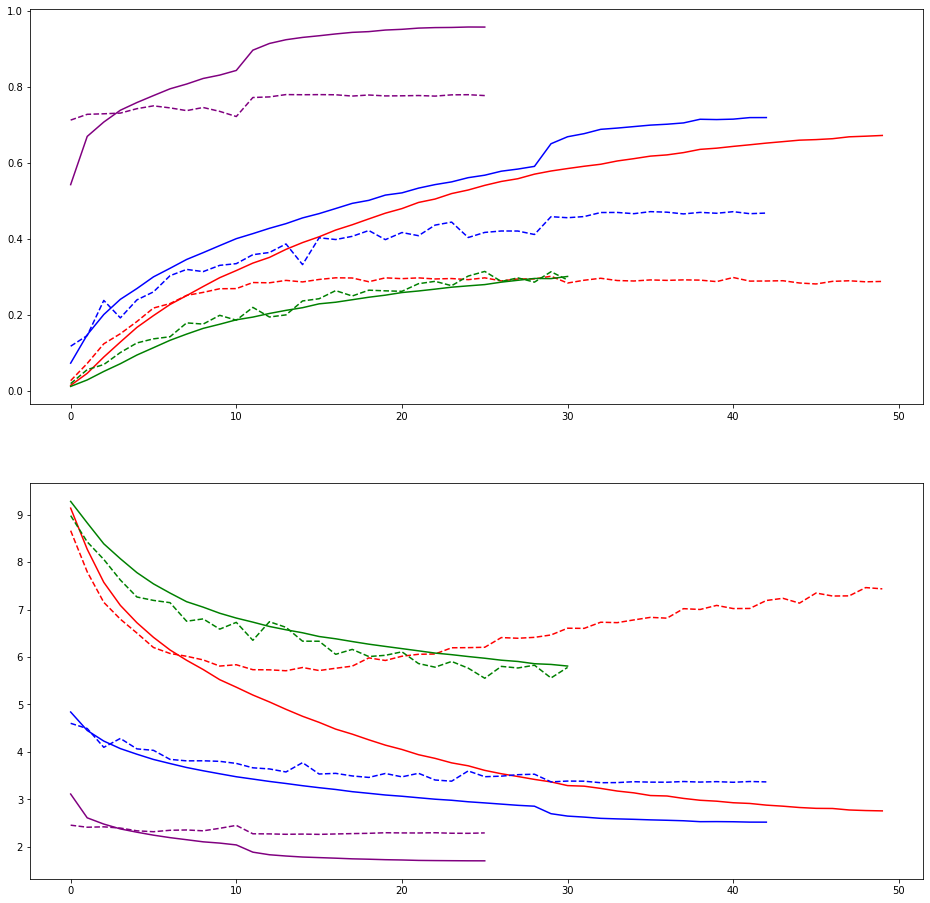

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(files, metrics, labels=None, linestyles=None, marker_styles=None, colors=None):
    data = {}    
    
    for i, f in enumerate(files):
        df = pd.read_csv(f, header=0, index_col=0)        
        if labels is not None:
            data[labels[i]] = df
        else:
            data[f] = df
            
    fig, axes = plt.subplots(len(metrics), 1, figsize=(16,16))
    
    for m, ax in zip(metrics, axes):        
        met_df = []
        for i, (lbl, df) in enumerate(data.items()):
            train_m, val_m = None, None
            for c in df.columns:
                if m in c and 'val' not in c:
                    train_m = c
                elif m in c and 'val' in c:
                    val_m = c
                    
            if linestyles is not None:
                ax.plot(df.index, df[train_m], linestyle=linestyles[0], color=colors[i])
                ax.plot(df.index, df[val_m], linestyle=linestyles[1], color=colors[i])
            else:
                ax.plot(df.index, df[train_m], label=lbl)
                ax.plot(df.index, df[val_m], label=lbl)
            
files = [os.path.join('eval',f) for f in sorted(os.listdir('eval'))]  
print(files)
metrics = ['accuracy', 'loss']
linestyles= ['-', '--']
labels = ['Inception-mod-base', 'Inception-mod-data-aug-early-stop', 'Minception', 'Inception-Resnet-v2-pretrained']
colors = ['r', 'g', 'b', 'purple']
plot_metrics(files, metrics, labels, linestyles=linestyles, colors=colors)
            
    
    

## Implementing GradCam
Paper: https://arxiv.org/pdf/1610.02391.pdf

In [38]:
K.clear_session()
model = load_model(os.path.join('models','inception_resnet_v2.h5'))

def unwrap_model(model):
    inception = model.get_layer('inception_resnet_v2')
    inp = inception.input
    out = model.get_layer('dropout')(inception.output)
    out = model.get_layer('dense')(out)
    return Model(inp, out)   
    
unwrapped_model = unwrap_model(model)

unwrapped_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [39]:
img_path = 'data/tiny-imagenet-200/val/images/val_434.JPEG'

val_df = pd.read_csv(os.path.join('data','tiny-imagenet-200', 'val', 'val_annotations.txt'),sep='\t', index_col=0, header=None)
with open(os.path.join('data','class_indices'),'rb') as f:
    class_indices = pickle.load(f)
words = pd.read_csv(os.path.join('data','tiny-imagenet-200', 'words.txt'), sep='\t', index_col=0, header=None)

def get_image_class_label(img_path, val_df, class_indices, words):
    
    img = np.expand_dims(np.asarray(Image.open(img_path).resize((224,224)), dtype='float32'), axis=0)
    img /= 127.5
    img -= 1
    if img.ndim == 3:
        img = np.repeat(np.expand_dims(img, axis=-1), 3, axis=-1)
    _, img_name = os.path.split(img_path)
    wnid = val_df.loc[img_name,1]
    cls = class_indices[wnid]
    label = words.loc[wnid, 1]
    return img, cls, label

img, cls, label = get_image_class_label(img_path, val_df, class_indices, words)


In [45]:
last_conv_layer = 'conv_7b'

# There's an issue between inner model input and outer model input connection
# to fix that we feed the same input to both these inputs
grad_model = Model(
    inputs=unwrapped_model.inputs, 
    outputs=[unwrapped_model.get_layer(last_conv_layer).output, unwrapped_model.output]    
)

image_fnames = [os.path.join('data','tiny-imagenet-200', 'val','images',f) \
                for f in ['val_9917.JPEG', 'val_9816.JPEG', 'val_9800.JPEG', 'val_9673.JPEG', 'val_9470.JPEG',\
                         'val_4.JPEG', 'val_127.JPEG', 'val_120.JPEG', 'val_256.JPEG', 'val_692.JPEG']]

grad_info = {}
for fname in image_fnames:
    img, cls, label = get_image_class_label(fname, val_df, class_indices, words)
    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img)
        loss = preds[:, cls]
    
    grads = tape.gradient(loss, conv_output)
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
    grads *= weights
    grads = tf.reduce_sum(grads, axis=(0,3))
    grads = tf.nn.relu(grads)

    # normalize 
    grads /= tf.reduce_max(grads)
    grads = tf.cast(grads*255.0, 'uint8')
    
    grad_info[fname] = {'image': img, 'class': cls, 'label':label, 'gradcam': grads}

print("Collected {} GradCAMs".format(len(grad_info)))

d  (1, 224, 224, 3)
Collected 10 GradCAMs


For  0  got offset  0
For  1  got offset  2
For  2  got offset  0
For  3  got offset  2
For  4  got offset  0
For  5  got offset  2
For  6  got offset  0
For  7  got offset  2
For  8  got offset  0
For  9  got offset  2


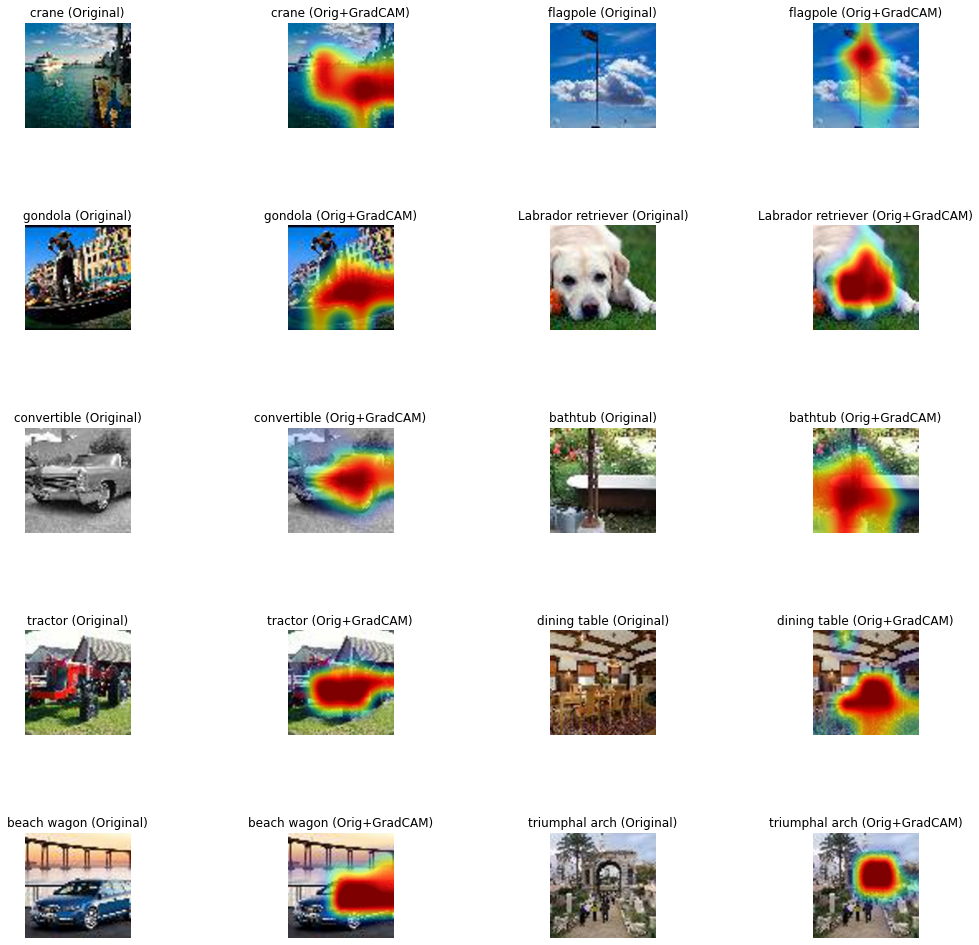

In [56]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# get colormap
ncolors = 256
cmap_name = 'jet'
color_array = plt.get_cmap(cmap_name)(range(ncolors))
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='{}_alpha'.format(cmap_name),colors=color_array)
# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

f, axes = plt.subplots(5, 4, figsize=(16,18))
plt.subplots_adjust(wspace=1.5)
for i, (k, v) in enumerate(grad_info.items()):
    
    cam = np.array(Image.fromarray(v["gradcam"].numpy()).resize((224,224)))
    orig_image = ((v["image"][0]+1)*127.5).astype('uint8')
    offset = 2*(i%2)
    print("For ", i, " got offset ", offset)
    axes[i//2][offset].imshow(orig_image)
    axes[i//2][offset+1].imshow(orig_image)
    axes[i//2][offset+1].imshow(cam,cmap='{}_alpha'.format(cmap_name))
    axes[i//2][offset].set_title(v["label"].split(',')[0]+ " (Original)")
    axes[i//2][offset+1].set_title(v["label"].split(',')[0] + " (Orig+GradCAM)")
    #plt.colorbar(mappable=h)
    axes[i//2][offset].axis('off')
    axes[i//2][offset+1].axis('off')

In [86]:
from tensorflow.keras.applications import InceptionResNetV2
import tensorflow as tf

model = InceptionResNetV2(include_top=True, pooling='avg')
model.summary()
IMAGE_PATH = 'data/tiny-imagenet-200/val/images/val_29.JPEG'
LAYER_NAME = 'conv_7b'
CAT_CLASS_INDEX = 25
        
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer).output, model.output])

with tf.GradientTape() as tape:
    print(type(np.array([img])))
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]
print(grads)


Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 149, 149, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 149, 149, 32) 0           batch_normalization_203[0][0]    
________________________________________________________________________________

<class 'numpy.ndarray'>
tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]], shape=(5, 5, 1536), dtype=float32)


In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.applications import InceptionResNetV2
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np

K.clear_session()

inception = InceptionResNetV2(include_top=False, pooling='avg')

out = Dropout(0.5)(inception.output)
out = Dense(200, activation='softmax')(out)

model = Model(inception.input, out)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

IMAGE_PATH = 'data/tiny-imagenet-200/val/images/val_29.JPEG'
LAYER_NAME = 'conv_7b'
CAT_CLASS_INDEX = 25
        
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

with tf.GradientTape() as tape:
    preds = model(np.array([img]))
    
print(model.inputs)
#print(model.layers)
#print(model.layers[1].get_layer(last_conv_layer).output)

grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:    
    conv_outputs, predictions = grad_model(np.array([img]))
    print(conv_outputs.shape)
    print(predictions.shape)
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(predictions, conv_outputs)[0]
print(grads)


[<tf.Tensor 'input_1:0' shape=(None, None, None, 3) dtype=float32>]
(1, 5, 5, 1536)
(1, 200)
tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]], shape=(5, 5, 1536), dtype=float32)


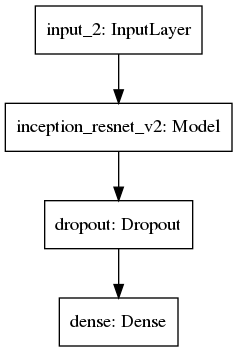

In [3]:
tf.keras.utils.plot_model(new_model)


In [6]:
tf.keras.utils.plot_model(new_model.layers[1], to_file='resnet.png')